# Lotka-Volterra Work-Precision Diagrams

Adapted from 
[SciMLBenchmarks.jl Lotka-Volterra benchmark](https://benchmarks.sciml.ai/html/NonStiffODE/LotkaVolterra_wpd.html).

In [1]:
# Imports
using LinearAlgebra, Statistics
using OrdinaryDiffEq, ParameterizedFunctions, ODEInterfaceDiffEq, LSODA, Sundials, DiffEqDevTools
using Plots
using ProbNumDiffEq

In [2]:
# Plotting theme
theme(:dao;
    linewidth=8,
    linealpha=0.7,
    markersize=5,
    markerstrokewidth=0.5,
    legend=:outerright,
)

## Problem Definition

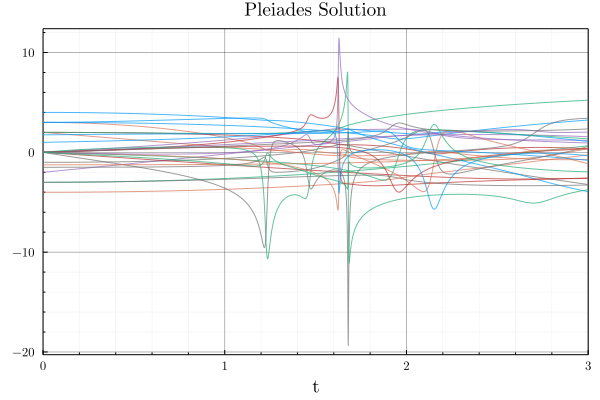

In [3]:
# Problem definition and reference solution
f = (du,u,p,t) -> begin
  @inbounds begin
  x = view(u,1:7)   # x
  y = view(u,8:14)  # y
  v = view(u,15:21) # x′
  w = view(u,22:28) # y′
  du[1:7] .= v
  du[8:14].= w
  for i in 15:28
    du[i] = zero(u[1])
  end
  for i=1:7,j=1:7
    if i != j
      r = ((x[i]-x[j])^2 + (y[i] - y[j])^2)^(3/2)
      du[14+i] += j*(x[j] - x[i])/r
      du[21+i] += j*(y[j] - y[i])/r
    end
  end
  end
end

prob = ODEProblem(f,[3.0,3.0,-1.0,-3.0,2.0,-2.0,2.0,3.0,-3.0,2.0,0,0,-4.0,4.0,0,0,0,0,0,1.75,-1.5,0,0,0,-1.25,1,0,0],(0.0,3.0))

abstols = 1.0 ./ 10.0 .^ (6:9)
reltols = 1.0 ./ 10.0 .^ (3:6);

sol = solve(prob,Vern8(),abstol=1/10^12,reltol=1/10^10,maxiters=1000000)
test_sol = TestSolution(sol);
plot(sol, title="Pleiades Solution", legend=false, linewidth=1)

## Low Order

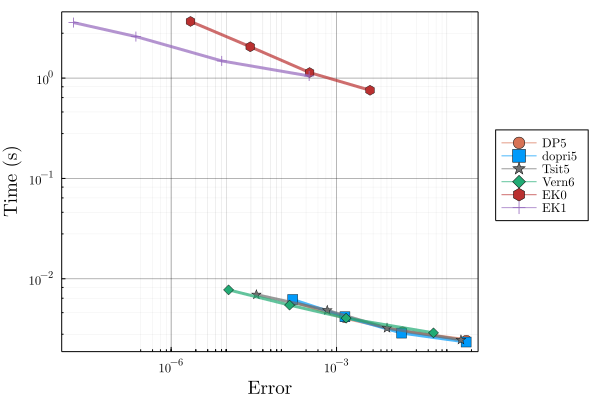

In [4]:
setups = [Dict(:alg=>DP5())
          Dict(:alg=>dopri5())
          Dict(:alg=>Tsit5())
          Dict(:alg=>Vern6())
          Dict(:alg=>EK0(order=4, smooth=false))
          Dict(:alg=>EK1(order=5, smooth=false))
]
wp = WorkPrecisionSet(prob,abstols,reltols,setups;
    appxsol=test_sol,save_everystep=false,maxiters=100000,numruns=10)
plot(wp)

## Interpolation Error

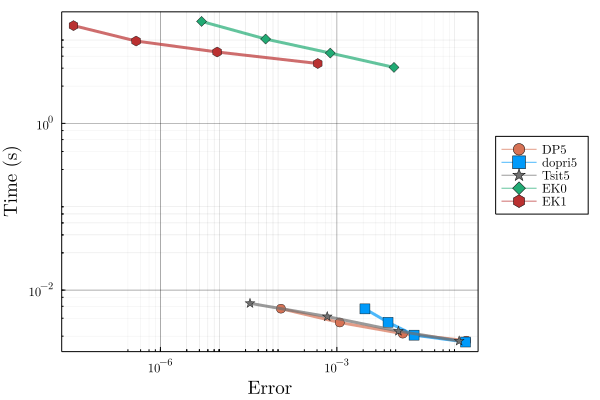

In [5]:
setups = [Dict(:alg=>DP5())
          Dict(:alg=>dopri5())
          Dict(:alg=>Tsit5())
          #Dict(:alg=>Vern6()) # Does not work for some reason
          Dict(:alg=>EK0(order=4))
          Dict(:alg=>EK1(order=5))
]
wp = WorkPrecisionSet(prob,abstols,reltols,setups;
    appxsol=test_sol,maxiters=1000000,error_estimate=:L2,dense_errors=true,numruns=10)
plot(wp)

## Higher Order

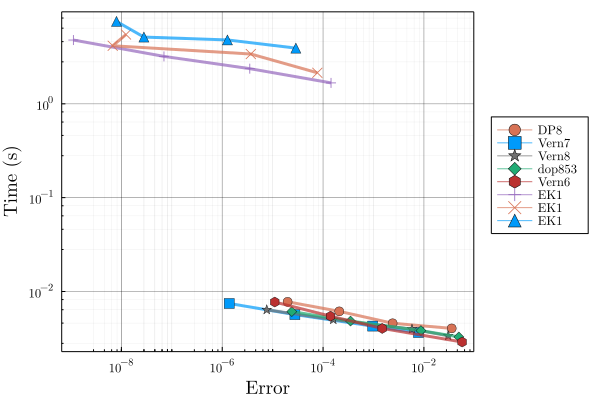

In [6]:
setups = [Dict(:alg=>DP8())
          Dict(:alg=>Vern7())
          Dict(:alg=>Vern8())
          Dict(:alg=>dop853())
          Dict(:alg=>Vern6())
          Dict(:alg=>EK1(order=6, smooth=false))
          Dict(:alg=>EK1(order=7, smooth=false))
          Dict(:alg=>EK1(order=8, smooth=false))
]
wp = WorkPrecisionSet(prob,abstols,reltols,setups;appxsol=test_sol,save_everystep=false,maxiters=100000,numruns=10)
plot(wp)

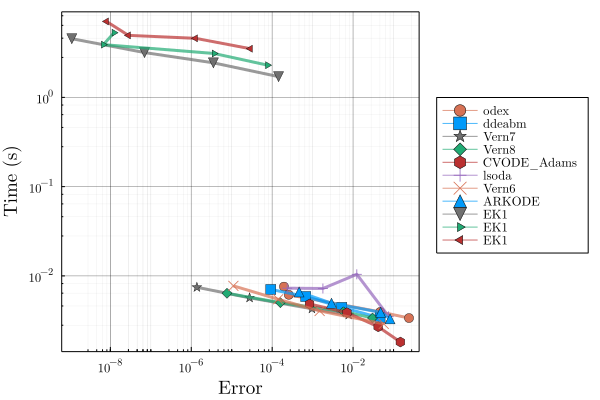

In [9]:
setups = [Dict(:alg=>odex())
          Dict(:alg=>ddeabm())
          Dict(:alg=>Vern7())
          Dict(:alg=>Vern8())
          Dict(:alg=>CVODE_Adams())
          Dict(:alg=>lsoda())
          Dict(:alg=>Vern6())
          Dict(:alg=>ARKODE(Sundials.Explicit(),order=6))
          Dict(:alg=>EK1(order=6, smooth=false))
          Dict(:alg=>EK1(order=7, smooth=false))
          Dict(:alg=>EK1(order=8, smooth=false))
          ]
wp = WorkPrecisionSet(prob,abstols,reltols,setups;
    appxsol=test_sol,save_everystep=false,maxiters=100000,numruns=10)
plot(wp)

### Interpolation again

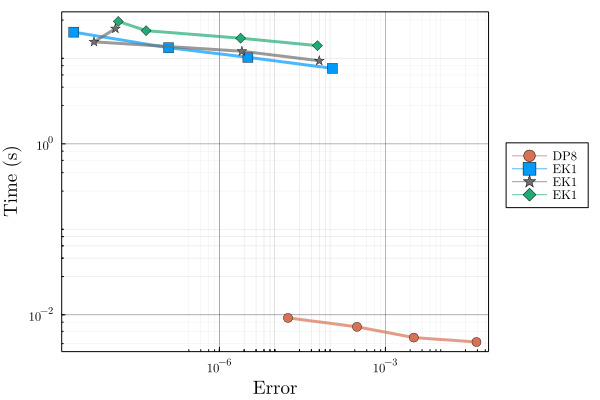

In [8]:
setups = [Dict(:alg=>DP8())
          # For some reason these don't work
          #Dict(:alg=>Vern7())
          #Dict(:alg=>Vern8())
          #Dict(:alg=>Vern6())
          Dict(:alg=>EK1(order=6))
          Dict(:alg=>EK1(order=7))
          Dict(:alg=>EK1(order=8))
]
wp = WorkPrecisionSet(prob,abstols,reltols,setups;
    appxsol=test_sol,dense=true,maxiters=100000,error_estimate=:L2,numruns=10)
plot(wp)